# Clean FERC Form 1

#### Setup

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Standard libraries
import logging
import sys
import os
import pathlib

# 3rd party libraries
import geopandas as gpd
import dask.dataframe as dd
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy as sa
import pickle

# Local libraries
import pudl
from pudl.analysis.fill_ferc1_fuel_gaps import *

In [4]:
# Enable viewing of logging outputs
logger=logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

In [5]:
# Display settings
sns.set()
%matplotlib inline
mpl.rcParams['figure.dpi'] = 75
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [6]:
# Establish connection to pudl database
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings['pudl_db'])
pudl_out = pudl.output.pudltabl.PudlTabl(
    pudl_engine=pudl_engine,
    freq='AS'
)

**Don't touch these for now -- loading them takes FOREVER. Use pickle instead**

In [7]:
ferc1_years = pudl.constants.working_partitions['ferc1']['years']
ferc1_tables = ['fuel_ferc1','plants_steam_ferc1'] 
ferc1_raw_dfs = pudl.extract.ferc1.extract(
        ferc1_tables=ferc1_tables,
        ferc1_years=ferc1_years,
        pudl_settings=pudl_settings)

Converting extracted FERC Form 1 table fuel_ferc1 into a pandas DataFrame.
Converting extracted FERC Form 1 table plants_steam_ferc1 into a pandas DataFrame.


In [8]:
ferc1_transformed_dfs = pudl.transform.ferc1.transform(
         ferc1_raw_dfs, ferc1_tables=ferc1_tables)

Transforming raw FERC Form 1 dataframe for loading into fuel_ferc1
Transforming raw FERC Form 1 dataframe for loading into plants_steam_ferc1
Identifying distinct large FERC plants for ID assignment.
slimming fuel table
running fbp table
merging fractions with steam
traning classifier with default weights
generating groups of similar records
Successfully associated 22138 of 29270 (75.63%) FERC Form 1 plant records with multi-year plant entities.
Assigning IDs to multi-year FERC plant entities.
Identified 4695 orphaned FERC plant records. Adding orphans to list of plant entities.
Successfully Identified 2074 multi-year plant entities.
Found report_year=1994 3 times in plant_id_ferc1=93
Found report_year=1994 2 times in plant_id_ferc1=316
Found report_year=1995 2 times in plant_id_ferc1=316
Found report_year=1996 2 times in plant_id_ferc1=316
Found report_year=1997 2 times in plant_id_ferc1=316
Found report_year=1998 2 times in plant_id_ferc1=316
Found report_year=1999 2 times in plant_i

In [10]:
with open('/Users/aesharpe/Desktop/ferc1_transformed2.pickle', 'wb') as handle:
    pickle.dump(ferc1_transformed_dfs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
with open('/Users/aesharpe/Desktop/ferc1_transformed2.pickle', 'rb') as handle:
    ferc1_transformed_dfs = pickle.load(handle)

with open('/Users/aesharpe/Desktop/steam_w_eia.pkl', 'rb') as handle:
    steam_w_eia = pickle.load(handle)

In [12]:
# Load the tables you'll need with some basic alterations
steam = ferc1_transformed_dfs['plants_steam_ferc1'].copy()
glue_dicts = pudl.glue.ferc1_eia.glue(ferc1=True) # For steam you'll have to mimic the glue process to get plant_id_pudl and add a column for primary fuel
steam = pd.merge(steam, glue_dicts['plants_ferc1'], on=['plant_name_ferc1', 'utility_id_ferc1'], how='left')
steam = pd.merge(steam, glue_dicts['utilities_ferc1'][['utility_id_ferc1', 'utility_name_ferc1']], on=['utility_id_ferc1'], how='left')
steam['primary_fuel'] = np.nan # Add column to document primary fuel

In [13]:
value_cols_no_cap = [
    'net_generation_mwh','avg_num_employees',
    'capex_land', 'capex_equipment', 'capex_structures', 'capex_total', 'asset_retirement_cost',
    'opex_operations', 'opex_fuel', 'opex_coolants', 'opex_steam', 'opex_steam_other', 'opex_transfer', 
    'opex_electric', 'opex_misc_power', 'opex_rents', 'opex_allowances', 'opex_engineering', 'opex_structures', 
    'opex_boiler', 'opex_plants', 'opex_misc_steam', 'opex_production_total'
]

value_cols = value_cols_no_cap + ['capacity_mw']

test_view = ['report_year', 'utility_name_ferc1', 'plant_name_ferc1', 'plant_id_pudl', 
             'plant_id_ferc1', 'primary_fuel', 'plant_type', 'record_id', 'capacity_mw']

total_view = test_view + ['total_type']

ferc_merge_cols = ['report_year', 'utility_id_ferc1', 'plant_name_ferc1']
eia_merge_cols = ['report_date', 'plant_id_pudl', 'generator_id']

## Fill in missing fuel

In [142]:
steam_with_fuel = impute_fuel_type(steam, pudl_out)

filling fuels with obvious names
26492 / 28514
filling in primary fuel by mmbtu
3421 / 28514
filling in eia plants with one reported fuel
2178 / 28564
filling in primary fuel by cost
1925 / 28564
filling in raw ferc1 fuels
1769 / 28564
filling in ferc plants with one fuel
1045 / 28564
filling in pudl plants with one fuel
946 / 28564
filling in manually mapped fuels
861 / 28564
front and backfilling values with the same ferc1 id
636 / 28564


In [143]:
steam_with_plant_type = impute_plant_type(steam_with_fuel)

filling plants with obvious names
761 / 28564
filling in manually mapped plant types


## Streamline fuel column by flipping outliers

In [144]:
flip_fuels_ferc1 = (
    steam_with_plant_type.pipe(flip_one_outlier_all, group_level='plant_id_ferc1')
    .pipe(flip_fuel_outliers_all, max_group_size=6)
)    

flipping single fuel outliers for plant_id_ferc1
636 / 28564
flipping multiple fuel outliers
636 / 28564


In [145]:
flip_fuels_pudl = (
    flip_fuels_ferc1.assign(plant_type=lambda x: x.plant_type.fillna('unknown'))
    .pipe(flip_one_outlier_all, group_level='plant_id_pudl')
)

flipping single fuel outliers for plant_id_pudl
636 / 28564


In [175]:
# Way to find gas --> coal outliers
#tt.groupby('plant_id_ferc1').apply(lambda x: pudl.analysis.fill_ferc1_fuel_gaps.create_groups(x, 'primary_fuel'))

[481]
heyyyy so this one has a gas to coal...
[925]
heyyyy so this one has a gas to coal...
[934]
heyyyy so this one has a gas to coal...
[940]
heyyyy so this one has a gas to coal...
[1224]
heyyyy so this one has a gas to coal...
[1225]
heyyyy so this one has a gas to coal...
[1294]
heyyyy so this one has a gas to coal...
[1342]
heyyyy so this one has a gas to coal...
[1886]
heyyyy so this one has a gas to coal...


plant_id_ferc1
1       (((1,       utility_id_ferc1  report_year plan...
2       (((1,       utility_id_ferc1  report_year plan...
3       (((1,       utility_id_ferc1  report_year plan...
4       (((1,       utility_id_ferc1  report_year plan...
5       (((1,       utility_id_ferc1  report_year     ...
                              ...                        
6765    (((1,       utility_id_ferc1  report_year plan...
6766    (((1,       utility_id_ferc1  report_year plan...
6767    (((1,       utility_id_ferc1  report_year plan...
6768    (((1,       utility_id_ferc1  report_year plan...
6769    (((1,       utility_id_ferc1  report_year plan...
Length: 6393, dtype: object

In [ ]:
# Notes from learning how to flip fuels:

# * ferc_id 601 -- one outlier fuel (same) on either end
# * ferc_id 839 -- turns then all to oil, but the majority are still gas--just three oil at the beginning :/
# * pudl_id 284 -- has ferc_ids allll over the place
# * pudl_id 307 -- has ferc_ids allll over the place
# * ferc_id 194 -- has one for coal left at the top...could benefit from one more "stragglers" clean through
# * ferc_id 713 -- same but an oil at the bottom
# * ferc_id 190 -- still has one bb gas at the top b/c not technically a single outlier. Might be ok to make function to clean ends if there is only ONE fuel?
# * ferc_id 554 -- has NAs and two single fuels....fill get filled in with bfill() but might not be right
# * ferc_id 64 -- an interesting case where the order of which fuel gets flipped impacts the outcome...might want to employ a way to start by flipping things that aren't the majority fuel?

## Flag double counted rows

* **plant total:** pudl plant totals where the plant is owned by more than one utility.
* **utility owned total:** all of the assets owned by a utility
* **utility owned plant total:** a utility's owned portion of a pudl plant
* **utility owned plant total steam:** all of the utility's steam assets within a given pudl plant
* **utility owned plant total nuclear:** all of the utility's nuclear assets within a given pudl plant
* **utility owned subtotal:** the sum of several units within a pudl plant owned by one utility
* **utility owned plant extra:** any extra amounts that are associated with a plant
* **utility owned extra:** any extra amounts that are associated with all a utility's assets
* **unit total:** the sum of a co-owned unit (sub-pudl plant id)

In [213]:
# Running list of fun problems:
# * If the plant total has a different plant type than the reporting utilitys' then it will come up as it's own 
#   row, probably NA :/
# * When to use total row if there are some components available
# * Unit totals - sometimes can under report (like in avg_emp 343) or over report (like in avg_emp 295)
# * 

In [210]:
# To investigate: 
# common, combined, cbd, cmbd, general, all plants, &, exps.-all combustion, unknown....look for these and # 1 unit

#### Functions

In [13]:
# NOT USED
def flag_totals(steam_table):
    """Preliminarily mark the rows with total indicated in the plant name."""
    regex1 = r'(?i)tot[a-z]*' # Find anything that would resembles TOTAL in the plant name
    regex2 = '100%' # Find all names with 100% in them
    regex3 = 'ttl ' # the space at the end is important
    regex4 = r'\(all' # find any names with '(all' in them
    
    steam_table['total'] = steam_table['plant_name_ferc1'].str.contains('|'.join([regex1, regex2, regex3])) #regex4
    ser_no_octo = steam_table[steam_table['plant_name_ferc1'].str.contains('octotillo')].total == False
    steam_table['total'].update(ser_no_octo) # remove octotillio from total = True because it accidentally fits in the 'tot' regex
    
    return steam_table

In [14]:
# idk where to put 'combined' b/c could be utility owned or plant total
total_plant_list = ['total plant', 'plant total', 'total plt', 'ttl plt', 'tot. plt.', '100%', 'ttl p']
extra_list = ['common', 'maint.', 'exp', 'misc', 'facilities', 'residual', 'various']
gt_list = ['gt', 'g t', 'g.t', 'g. t']
cost_list = ['chgs', 'indirect', 'exp']

def flag_specific_totals(df, col_name):
    
    def is_total(row):
        if any(x in row for x in total_plant_list):
            return 'plant total' # some of these could be utility owned plant totals....
        elif 'general' in row and 'general electric' not in row:
            return 'utility owned total' # but is it a duplicate or is it extra...
        elif any(x in row for x in extra_list): # order matters here
            return 'utility owned extra'
        elif any(x in row for x in ['chgs', 'indirect']) and any(x in row for x in gt_list):
            return 'utility owned combustion turbine extra'
        elif any(x in row for x in cost_list) and 'comb' in row:
            return 'utility owned combustion turbine extra'       
        elif any(x in row for x in cost_list) and 'steam' in row:
            return 'utility owned steam extra'
        elif any(x in row for x in cost_list) and 'nuclear' in row:
            return 'utility owned nuclear extra'
        else:
            return None
    
    df[col_name] = df.apply(lambda x: is_total(x.plant_name_ferc1), axis=1)
    
    return df

In [15]:
def backfill_by_capacity_all(df):
    """Add the same total flag to rows in the same plant_id with the same capacity."""
    def backfill_by_capacity(df_group):
        # First make sure there is a total type otherwise just return the df
        if df_group.total_type.isna().all():
            return df_group
        # If there is a total row...
        else:
            # Make a dictionary of total types to capacity -- capacity must be the key or else duplicate total types
            # (in the case of two utilities reporting a total for the same plant) will get deleted even if they have
            # different capacities. B/C key must be unique.
            tot_df = df_group[df_group['total_type'].notna()]
            capacity_dict = dict(zip(tot_df['capacity_mw'], tot_df['total_type']))
            for cap, total_type in capacity_dict.items():
                if cap > 0:
                    df_group.loc[(df_group['capacity_mw']==cap) & (df_group['total_type'].isna()), 'total_type'] = total_type
                    return df_group
                else:
                    return df_group
    
    out_df = df.groupby(['plant_id_pudl']).apply(lambda x: backfill_by_capacity(x))
    return out_df

In [146]:
# Flag bad/total rows
flagged_steam = (
     flip_fuels_pudl
     .pipe(flag_specific_totals, col_name='total_type')
     .pipe(pudl.analysis.fill_ferc1_fuel_gaps.add_manual_values, 'total_type_manual', '/Users/aesharpe/Desktop/manual_total_types.xlsx')
     .pipe(backfill_by_capacity_all)
     #.assign(primary_fuel = lambda x: x.primary_fuel.fillna('unknown'))
)

#### Investigate fuel-tech pairings (with an eye for totals)

In [147]:
fs = flagged_steam[total_view+['primary_fuel_flag']].copy()
fs = fs.assign(
    primary_fuel=fs.primary_fuel.fillna('unknown'), 
    plant_type=fs.plant_type.fillna('unknown'))
fs['tech-fuel'] = fs.primary_fuel + '_' + fs.plant_type

In [188]:
tec_li = eia['technology_description'].unique().tolist()
tec_li = [x for x in tec_li if x!=None]
[x for x in tec_li if 'Coal' in x]

['Conventional Steam Coal', 'Coal Integrated Gasification Combined Cycle']

In [189]:
tech_list = fs['tech-fuel'].unique().tolist()
[x for x in tech_list if 'coal' in x]

['coal_steam',
 'coal_combustion_turbine',
 'coal_internal_combustion',
 'coal_combined_cycle',
 'coal_unknown']

In [149]:
for tech in tech_list:
    print(tech)
    print(len(fs[fs['tech-fuel']==tech]))

coal_steam
9574
gas_steam
2975
nuclear_nuclear
1707
unknown_steam
217
gas_combustion_turbine
5872
oil_combustion_turbine
2433
gas_combined_cycle
1507
coal_combustion_turbine
727
oil_steam
773
unknown_unknown
234
gas_internal_combustion
544
coal_internal_combustion
102
oil_internal_combustion
834
oil_combined_cycle
33
waste_steam
65
unknown_combustion_turbine
169
unknown_internal_combustion
15
geothermal_geothermal
31
other_combustion_turbine
3
other_steam
18
coal_combined_cycle
33
wind_wind
170
oil_unknown
44
gas_unknown
121
coal_unknown
216
unknown_combined_cycle
1
solar_photovoltaic
135
solar_solar_thermal
10
solar_solar_photovoltaic
1


In [ ]:
# For testing some of these wierd ones

fs[fs['tech-fuel']=='coal_combustion_turbine']
#flagged_steam[flagged_steam['plant_name_ferc1'].str.contains('h.b. robinson')].sort_values('report_year')[total_view+['primary_fuel_flag']]
#flagged_steam[flagged_steam['plant_id_ferc1']==82][total_view+['primary_fuel_flag']]
#flagged_steam[flagged_steam['primary_fuel_flag']=='ferc pudl map all'].plant_id_ferc1.unique()
#flagged_steam[flagged_steam['plant_id_ferc1']==25][total_view+['primary_fuel_flag']]
fs[fs['plant_id_pudl']==305].sort_values('report_year')#.head(20)

### Investigate EIA technology description comparison

In [14]:
fbp = pudl_out.fbp_ferc1()
eia = (
    pudl_out.gens_eia860()#[['report_date', 'plant_id_pudl', 'generator_id', 'utility_name_eia', 'plant_name_eia', 'technology_description', 'fuel_type_code_pudl', 'capacity_mw']]
    .assign(report_year=lambda x: x.report_date.dt.year)
)

KeyboardInterrupt: 

In [425]:
eia_test = eia[eia['plant_id_pudl']==305]
ferc_test = fs[fs['plant_id_pudl']==305]

# Get eia plants with only one technology description (besides NA)
eia_one_tech = (
    eia.groupby('plant_id_pudl').filter(lambda x: len(x.technology_description.dropna().unique())==1)
    [['report_year', 'plant_id_pudl', 'technology_description']].drop_duplicates()
    .assign(dup=lambda x: x.duplicated(subset=['report_year', 'plant_id_pudl'], keep=False))
)
# Drop None cases when there is a None and a Tech Desc. for the same plant and year (so there is one per plant-year)
eia_one_tech = eia_one_tech.drop(eia_one_tech[(eia_one_tech['dup']==True) & (eia_one_tech['technology_description'].isna())].index)
eia_one_tech_list = list(eia_one_tech.plant_id_pudl.unique())

# Get the technology description associated with the plant regardless of year...
plant_id_tech_type = (
    eia_one_tech.groupby(['plant_id_pudl']).agg({'technology_description':lambda x: x.dropna().unique().item()})
    .rename(columns={'technology_description': 'same_tech'})
)

In [426]:
# Number of total plants in the steam table
print(len(steam.plant_id_pudl.unique()))
# VS number of plants in the steam table that coorespond to EIA plants with a single technology description
print(len([x for x in eia_one_tech_list if x in steam.plant_id_pudl.unique()]))

1482
706


In [355]:
# Check the construction_year and installation_year fields
def check_for_new_units(df, year_col, bool_col):
    init_years = df[df['report_year']==df.report_year.min()][year_col].unique()
    
    df[f'{bool_col}'] = ~df[f'{year_col}'].isin(init_years)
    
    return df

In [356]:
# Make columns to see if there have been any unit additions or retirements
steam2 = (
    steam.groupby(['plant_id_pudl']).apply(lambda x: check_for_new_units(x, 'construction_year', 'retired_unit'))
    .groupby(['plant_id_pudl']).apply(lambda x: check_for_new_units(x, 'installation_year', 'new_unit'))
)

In [466]:
# Merge the eia single technology descriptions with ferc1
merge_df = (
    pd.merge(steam2, eia_one_tech[['report_year', 'plant_id_pudl', 'technology_description']].drop_duplicates(), 
             on=['report_year', 'plant_id_pudl'], how='left')
)
merge_df2 = pd.merge(merge_df, plant_id_tech_type, on=['plant_id_pudl'], how='left')

ferc_eia_tech_desc = merge_df2[['report_year', 'plant_id_pudl', 'utility_id_ferc1', 'plant_name_ferc1', 'plant_type', 
                                'technology_description', 'same_tech', 'construction_year', 'retired_unit', 
                                'installation_year', 'new_unit']]

In [639]:
# List of plants from the MUL that have multiple tech descriptions in one pudl id
#steam_w_eia.groupby(['plant_id_pudl']).filter(lambda x: len(x.technology_description.dropna().unique())>1)['plant_id_pudl'].unique()

In [640]:
#steam_w_eia[steam_w_eia['plant_id_pudl']==178][['report_year', 'utility_id_ferc1', 'plant_name_ferc1', 'installation_year', 'construction_year', 'technology_description']]

In [511]:
len(ferc_eia_tech_desc[ferc_eia_tech_desc['technology_description'].notna()])

3050

In [512]:
len(ferc_eia_tech_desc[ferc_eia_tech_desc['same_tech'].notna()])

14567

In [456]:
hmm = ferc_eia_tech_desc[(ferc_eia_tech_desc['same_tech'].notna()) & (ferc_eia_tech_desc['technology_description'].isna())]

# Plants where not all records have an eia tech description AND there is a change in the installation year (aka there was a new unit added)
hmm[hmm['new_unit']==True].plant_id_pudl.unique()

array([1148, 113, 13, 133, 2297, 2532, 190, 394, 1620, 351, 1225, 117,
       147, 136, 1187, 122, 556, 1032, 2740, 457, 330, 440, 638, 283,
       1525, 546, 550, 627, 1177, 778, 464, 8327, 1381, 1128, 343, 1069,
       1157, 471, 1230, 215, 424, 1135, 205, 439, 545, 275, 2960, 224,
       267, 1108, 420, 182, 334, 11, 583, 7616, 2561, 8547, 200, 15, 548,
       1149, 527, 199, 235, 1083, 380, 18, 602, 1144, 140, 63, 317, 1169,
       4, 26, 374, 180, 1141, 1280, 258, 312, 295, 624, 22, 585, 125, 634,
       654, 183, 629, 56, 1297, 385, 239, 566, 1085, 241, 649],
      dtype=object)

In [458]:
nona = ferc_eia_tech_desc[ferc_eia_tech_desc['technology_description'].notna()]

#### Investigate Heat Rates -- not worth it because EIA fills in all the gaps where there is a heat rate

In [477]:
# Identify duplicate columns
fuel_dupes = (
    fuel.loc[fuel['fuel_type_code_pudl'] != 'unknown'].copy()
    .assign(dup=lambda x: x.duplicated(subset=ferc_merge_cols, keep=False)))

# Only take fuels from plants without duplicate name/utility/year combos
fuel_ferc_no_dup = (
    fuel_dupes[~fuel_dupes['dup']][[
        'report_year', 'utility_id_ferc1', 'plant_name_ferc1',
        'fuel_type_code_pudl', 'fuel_avg_heat_raw', 'fuel_qty_burned']].copy()  # keep fuel_avg_heat_raw and fuel_qty_burned in there for next round
    .rename(columns={'fuel_type_code_pudl': 'fuel_type_code_pudl_ferc'}))

hr_merge = pd.merge(ferc_eia_tech_desc, fuel_ferc_no_dup, on=ferc_merge_cols, how='left')

print(len(hr_merge))
print(len(ferc_eia_tech_desc))

29270
29270


In [579]:
hr_merge2 = hr_merge[hr_merge['technology_description'].notna()]
hr_merge3 = hr_merge2.groupby(['technology_description']).filter(lambda x: len(x.fuel_avg_heat_raw.dropna()) > 5)
hr_merge4 = hr_merge3[hr_merge3['fuel_avg_heat_raw'].notna()]

In [607]:
hr_merge[(hr_merge['same_tech'].isna()) & (hr_merge['fuel_avg_heat_raw'].notna())]

,report_year,plant_id_pudl,utility_id_ferc1,plant_name_ferc1,plant_type,technology_description,same_tech,construction_year,retired_unit,installation_year,new_unit,fuel_type_code_pudl_ferc,fuel_avg_heat_raw,fuel_qty_burned
6,1994,32,2,barry,steam,NaN,NaN,1954,False,1971,False,coal,11975.0,3739484.0
7,1994,108,2,chickasaw,steam,NaN,NaN,1941,False,1951,False,gas,1.0,40533.0
8,1994,178,2,e. c. gaston-unit 5,steam,NaN,NaN,1974,False,1974,False,coal,11961.0,2124933.0
11,1994,11538,2,resondent's portion,unknown,NaN,NaN,<NA>,False,<NA>,False,coal,12420.0,5372133.0
14,1994,8470,2,respondent's portion,unknown,NaN,NaN,<NA>,False,<NA>,False,coal,12145.0,817520.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29244,2019,413,22,nesbitt unit 1,steam,NaN,NaN,1975,False,1975,False,gas,1016842.0,6009634.0
29250,2019,581,22,teche 4,internal_combustion,NaN,NaN,2011,True,2011,True,gas,1077809.0,10504.0
29254,2019,261,227,hersey,combustion_turbine,NaN,NaN,1947,False,2000,True,gas,1057.0,267483.0
29256,2019,80,227,burnips,combustion_turbine,NaN,NaN,1937,False,2001,True,gas,1064.0,37529.0


Conventional Steam Coal : 58 median heat rate 8683.5
Municipal Solid Waste : 6 median heat rate 1020000.0
Natural Gas Fired Combined Cycle : 254 median heat rate 1020459.0
Natural Gas Fired Combustion Turbine : 377 median heat rate 1030.0
Natural Gas Internal Combustion Engine : 11 median heat rate 1020000.0
Natural Gas Steam Turbine : 63 median heat rate 1015113.0
Nuclear : 84 median heat rate 111765.0
Petroleum Liquids : 241 median heat rate 137133.0


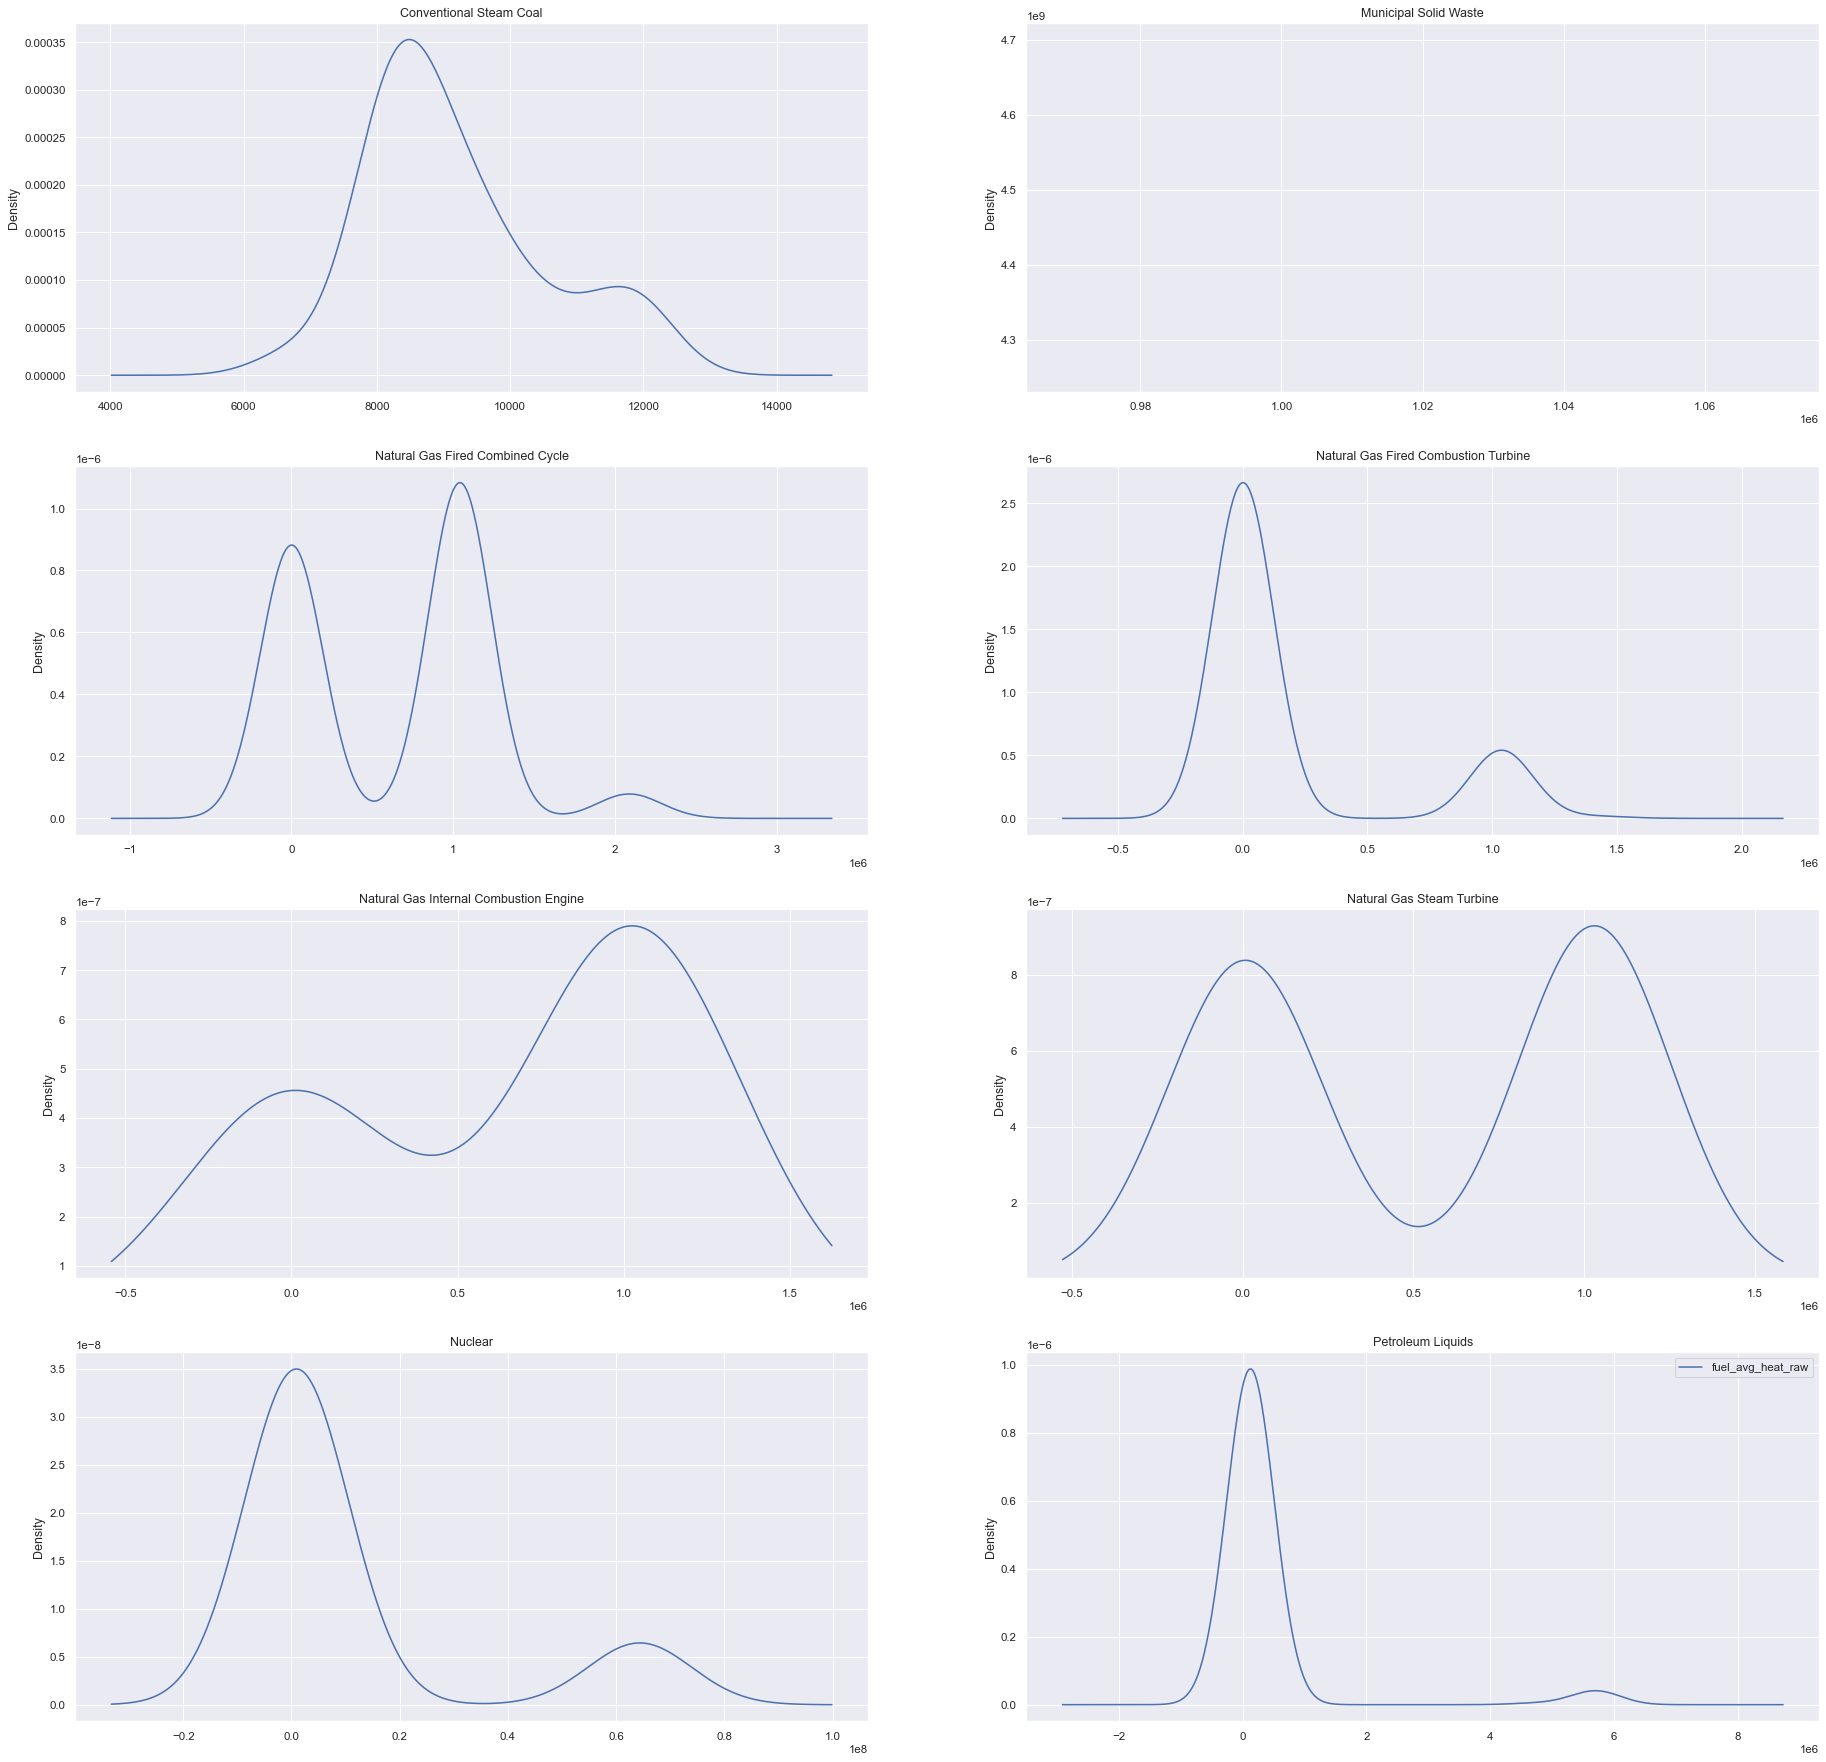

In [642]:
## looking into ploting heat rate to see if there are any reasonable assumptions to be made here like before
grouped = hr_merge4.groupby(['technology_description'])['fuel_avg_heat_raw']

ncols=2
nrows = int(np.ceil(grouped.ngroups/ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30,30), sharey=False)

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    print (key, ':', len(grouped.get_group(key)), 'median heat rate', grouped.get_group(key).median())
    ax.title.set_text(key)
    grouped.get_group(key).plot(ax=ax, kind='kde')

ax.legend()
plt.show()

#grouped.apply(lambda x: x.plot.kde())

<AxesSubplot:ylabel='Density'>

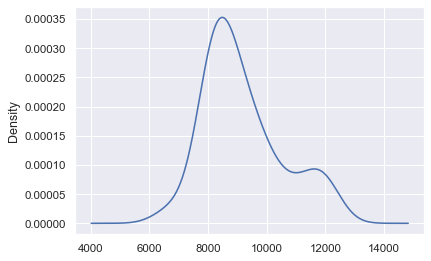

In [582]:
cc = hr_merge2[hr_merge2['technology_description'].isin(['Conventional Steam Coal'])] #.reset_index()
cc[cc['fuel_avg_heat_raw'].notna()]['fuel_avg_heat_raw'].plot.kde()

<AxesSubplot:ylabel='Density'>

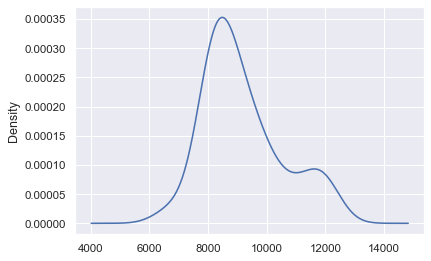

In [567]:
gg = cc.groupby(['technology_description'])['fuel_avg_heat_raw']
cc['fuel_avg_heat_raw'].plot(kind='kde')

In [491]:
grouped.groups.keys()

dict_keys(['Conventional Hydroelectric', 'Conventional Steam Coal', 'Geothermal', 'Landfill Gas', 'Municipal Solid Waste', 'Natural Gas Fired Combined Cycle', 'Natural Gas Fired Combustion Turbine', 'Natural Gas Internal Combustion Engine', 'Natural Gas Steam Turbine', 'Nuclear', 'Onshore Wind Turbine', 'Petroleum Liquids', 'Solar Photovoltaic', 'Wood/Wood Waste Biomass'])

#### Investigate Sub-Plant totals

In [280]:
z_util_list = flagged_steam[flagged_steam['total_type'].isin(['utility owned subtotal', 'unit total'])]['utility_id_ferc1'].unique().tolist()
z_plant_list = flagged_steam[flagged_steam['total_type'].isin(['utility owned subtotal', 'unit total'])]['plant_id_pudl'].unique().tolist()

test = flagged_steam[(flagged_steam['utility_id_ferc1'].isin(z_util_list)) & (flagged_steam['plant_id_pudl'].isin(z_plant_list))]
test

flagged_steam[flagged_steam['total_type'].isin(['utility owned subtotal'])]['plant_id_pudl'].unique()

array([623, 410, 556, 525])

In [111]:
# If the non totals have an NA value and the totals rows don't have an NA value then we want to know
dd = pd.DataFrame()
def check_unit_totals(df):
    non_tot = df[df['total_type'].isna()].drop(['total_type'], axis=1)
    tot = df[df['total_type'].notna()].drop(['total_type'], axis=1)
    
    non_tot_some_na = non_tot.isna().any()
    tot_some_values = tot.notna().any()
    
    dependencies = non_tot_some_na & tot_some_values
    
    if dependencies.any():
        print(list(df['report_year'].unique()))
        print(dependencies.where(dependencies).dropna())
        return(dependencies.where(dependencies))

In [209]:
z = flagged_steam[(flagged_steam['plant_id_pudl'].isin([295]))]
#test = z[z['plant_name_ferc1'].str.contains('1|2')]
#test = test[~test['plant_type'].isin(['combined_cycle'])]
#test = test[~test['plant_name_ferc1'].str.contains('100' and '1&')]
#dff = test.groupby(['report_year']).apply(lambda x: check_unit_totals(x))
#dff.to_excel('/Users/aesharpe/Desktop/pudl_id_525.xlsx')
#z[z['report_year'].isin(range(2009,2011))].sort_values(['report_year'])[test_view + ['total_type']]
#flagged_steam[flagged_steam['plant_name_ferc1'].str.contains('weston')].plant_id_pudl.unique()
#flagged_steam[flagged_steam['plant_id_pudl']==7887][test_view]

## Custom aggregation based on the presense of nulls and/or totals rows

#### Test Cases

In [212]:
test1_df = flagged_steam[(flagged_steam['plant_id_pudl']==123) & (flagged_steam['report_year'].isin(range(1994,1995)))]
df1 = test1_df[basic_view + ['capex_total', 'avg_num_employees']].copy()

test2_df = flagged_steam[(flagged_steam['plant_id_pudl']==2281) & (flagged_steam['report_year'].isin(range(1994,1995)))]
df2 = test2_df[basic_view + ['capex_total', 'avg_num_employees']].copy()

test3_df = flagged_steam[(flagged_steam['plant_id_pudl']==288) & (flagged_steam['report_year'].isin(range(1994,1995)))]
df3 = test3_df[basic_view + ['capex_total', 'avg_num_employees']]

#### Functions

In [240]:
# DOUBLE CHECK THE ORDER 

def agg_n_flag(flag_df, agg_col):
    """Aggregate specified column and create flag column based on total rows.
    
    """
    # If all non-ttl rows have values and there are more than 0 just add 'em up
    if (flag_df.loc[flag_df['total_type'].isna()][agg_col].notna().all()) & (len(flag_df.loc[flag_df['total_type'].isna()]) > 0): 
        flag = 'actual values provided--no need for totals'#None
        agg_value = flag_df.loc[flag_df['total_type'].isna()][agg_col].sum()
        return [agg_value, flag]
    
    # If there aren't any total rows, just take the sum cuz that's all you can do
    elif flag_df['total_type'].isna().all():
        flag = 'no total rows' #None
        agg_value = flag_df[agg_col].sum()
        return [agg_value, flag]
    
    # Now there ARE total rows and there ARE value rows with NA:
    # If the total rows are all NA for the agg col, just take the sum cuz that's all you can do
    elif flag_df[flag_df['total_type'].notna()][agg_col].isna().all():
        flag = 'totals are NA'
        agg_value = flag_df[agg_col].sum()
        return [agg_value, flag]
    
    # If there are only total rows there's probably an issue with plant/fuel type mapping
    elif flag_df['total_type'].notna().all():
        flag = 'all rows only totals...'
        agg_value = flag_df[agg_col].sum() # FIX 
        return [agg_value, flag]
    
    # If non-total value cols are all NA (and by default there are total rows with values):....FIX
    elif flag_df[flag_df['total_type'].isna()][agg_col].isna().all():
        flag = flag_df[flag_df[agg_col].notna()]['total_type'].unique()[0] # this might be bad...
        agg_value = flag_df[flag_df['total_type'].notna()][agg_col].sum()
        return [agg_value, flag]

    # If some non-total value cols are NA but not all (and by default there are total rows with values):
    else:
        flag = 'some values are NA but not all'
        agg_value = flag_df[agg_col].sum() # FIX
        return [agg_value, flag]

In [241]:
def run_the_thing(df, agg_col):
    print(f'starting aggregation for {agg_col}')
    plant_group = df.groupby(['report_year', 'utility_id_ferc1', 'plant_id_pudl', 'primary_fuel', 'plant_type'])
    col_agg_series = plant_group.apply(lambda x: agg_n_flag(x, agg_col))
    col_agg_df = pd.DataFrame(col_agg_series).reset_index()
    col_agg_df[[agg_col, f'{agg_col}_flag']] = pd.DataFrame(col_agg_df[0].tolist(), index=col_agg_df.index)
    col_agg_df = col_agg_df.drop(columns=[0])
    
    util_agg_df = (
        col_agg_df.groupby(['report_year', 'utility_id_ferc1', 'primary_fuel', 'plant_type'])
        .agg({agg_col: 'sum', f'{agg_col}_flag': lambda x: ', '.join(list(x.dropna().unique()))})
    )
    return util_agg_df

In [242]:
def run_the_whole_thing(df):
    agg_df = pd.DataFrame(columns=['report_year', 'utility_id_ferc1', 'primary_fuel', 'plant_type'])
    for col in value_cols:
        one_col_df = run_the_thing(df, col)
        #df_list.append(one_col_df)
        agg_df = pd.merge(agg_df, one_col_df, on=['report_year', 'utility_id_ferc1', 'primary_fuel', 'plant_type'], how='outer')
    return agg_df

In [243]:
whole_enchilada = run_the_whole_thing(flagged_steam)

starting aggregation for net_generation_mwh
starting aggregation for avg_num_employees
starting aggregation for capex_land
starting aggregation for capex_equipment
starting aggregation for capex_structures
starting aggregation for capex_total
starting aggregation for asset_retirement_cost
starting aggregation for opex_operations
starting aggregation for opex_fuel
starting aggregation for opex_coolants
starting aggregation for opex_steam
starting aggregation for opex_steam_other
starting aggregation for opex_transfer
starting aggregation for opex_electric
starting aggregation for opex_misc_power
starting aggregation for opex_rents
starting aggregation for opex_allowances
starting aggregation for opex_engineering
starting aggregation for opex_structures
starting aggregation for opex_boiler
starting aggregation for opex_plants
starting aggregation for opex_misc_steam
starting aggregation for opex_production_total
starting aggregation for capacity_mw


In [244]:
whole_enchilada.to_excel('/Users/aesharpe/Desktop/util_fuel_steam2.xlsx')

<AxesSubplot:>

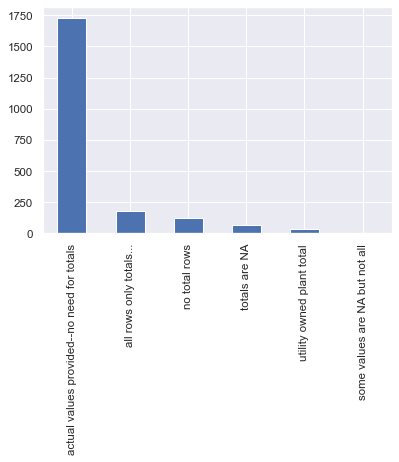

In [920]:
col_agg_df = col_agg_df.sort_values('plant_id_pudl')
#col_agg_df[col_agg_df['capex_total_flag'].str.contains('some values are NA but not all')]

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
col_agg_df['capex_total_flag'].value_counts().plot(ax=ax, kind='bar')

### Leftovers

In [ ]:
# Leftover net generation calculation stuff

# Combine fuel type from 860 with net generation from 923 to get fuel type and net generation
net_gen_fuel = (
    pd.merge(gens, net_gen[eia_merge_cols+['net_generation_mwh']], on=eia_merge_cols, how='outer')
    .assign(
        # Get plant net generation sums
        plant_net_gen=lambda x: (
            x.groupby(['report_date', 'plant_id_pudl']).net_generation_mwh.transform('sum')),
        # Calculate the portion of net generation that each row is responsible for
        gen_pct=lambda x: (
            x.net_generation_mwh / x.plant_net_gen * 100)
    )
)

# Calculate the sum portion of net generation attributable to each fuel type 
net_gen_fuel_sum = (
    net_gen_fuel.groupby(['report_date', 'plant_id_pudl', 'fuel_type_code_pudl'])['gen_pct']
    .sum()
    .reset_index()
    # Create flag to distinguish between rows that have more than one fuel (duplicates)
    .assign(dup=lambda x: x.duplicated(subset=['report_date', 'plant_id_pudl'], keep=False))
)

# Keep rows with only one fuel
one_fuel_eia = (
    net_gen_fuel_sum[~net_gen_fuel_sum['dup']].copy()
    .rename(columns={'fuel_type_code_pudl': 'primary_fuel_type_eia'})
    .assign(
        report_year=lambda x: x.report_date.dt.year,
        primary_fuel_type_eia=lambda x: x.primary_fuel_type_eia.replace({'':np.nan, 'unknown': np.nan, 'other': np.nan}))
    .drop(['report_date', 'gen_pct', 'dup'], axis=1)
)

# Combine steam table with EIA plant primary fuel type table, add flag to note fuel type location
steam3 = (
    pd.merge(steam2, one_fuel_eia, on=['report_year', 'plant_id_pudl'], how='left')
    .pipe(_add_new_fuel_and_flag, 'primary_fuel_type_eia', flag3)
    .pipe(_check_flags)
)

In [ ]:
# NOT USED
def compare_totals(flag_df, comp_col):
    """Sum non-total utility-plant reported values and compare to reported totals when applicable.
    
    This function takes in a DataFrame and calculates the sum value for both the plant and utility-plant
    groups on an annual basis and compares them with any reported totals. First, this function calculates
    group totals by excluding any rows flagged as totals or extraneous in the total_types row (i.e.:
    total_type.isna()). Then, it separates the DataFrame into two small DataFrames representing all
    the utility owned total rows and all of the plant total rows reported and flagged. Next, it
    compares the calculated group total against the reported group total and outputs a True/False
    boolean. The boolean flags from these small table comparisons are then subsumed into the larger 
    DataBase under the column names: utility_owned_total_flag and plant_total_flag.
    
    These columns will show users where there might be a reporting discrepancy and allows them to
    choose which value they might want to reply on for further calculation. This flag is not yet
    incorporated into the aggregation function below, but it could be!
    
    """
    def sum_no_totals(df, col):
        no_totals_df = df.loc[df['total_type'].isna()]
        return no_totals_df[col].sum()

    # Groupby utility-plant and plant
    plant_util_groups = flag_df.groupby(['report_year', 'utility_id_ferc1', 'plant_id_pudl'])
    plant_groups = flag_df.groupby(['report_year', 'plant_id_pudl'])

    # Get the sum of the values in each group that are not totals
    plant_util_total_series = plant_util_groups.apply(lambda x: sum_no_totals(x, comp_col))
    plant_total_series = plant_groups.apply(lambda x: sum_no_totals(x, comp_col))

    # Take that series of sums, reset the index, and give the sum column an informative name
    util_plant_df = pd.DataFrame(plant_util_total_series).reset_index().rename(columns={0:'plant_util_total'})
    plant_df = pd.DataFrame(plant_total_series).reset_index().rename(columns={0:'plant_total'})

    # Merge the two sum columns together on utility-plant
    df = pd.merge(plant_df, util_plant_df, on=['report_year', 'plant_id_pudl'], how='outer')
    comp_totals = pd.merge(flag_df, df, on=['report_year', 'utility_id_ferc1', 'plant_id_pudl'], how='outer')
    
    # Get slices of the dataframe that represent the utility owned total rows and the plant total rows to compare with calculated totals
    util_ot = comp_totals[comp_totals['total_type']=='utility owned total'].copy()
    plant_ot = comp_totals[comp_totals['total_type']=='plant total'].copy()

    # For each dataframe, flag whether the sum of the components (calculated above) equals the reported total
    # Could make this a little more flexible (+/- 1)
    util_ot['utility_owned_total_flag'] = np.where(util_ot['capacity_mw'] == util_ot['plant_util_total'], True, False)
    plant_ot['plant_total_flag'] = np.where(plant_ot['capacity_mw'] == plant_ot['plant_total'], True, False)
    
    # Create blank columns in the original dataframe
    comp_totals[f'{comp_col}_utility_owned_total_flag'] = None
    comp_totals[f'{comp_col}_plant_total_flag'] = None

    # Update those blank columns so that the True/False values from the prior calculations are added to the correct column
    comp_totals[f'{comp_col}_utility_owned_total_flag'].update(util_ot['utility_owned_total_flag'])
    comp_totals[f'{comp_col}_plant_total_flag'].update(plant_ot['plant_total_flag'])

    return comp_totals

In [ ]:
def col_aggregator(flag_df, agg_col):
    """
    Remove total rows from aggregation; use when there are nulls present in non-total rows. 
    
    This function looks at a table grouped by year, utility, and plant and determines whether to use any of the
    information from the total rows in an aggregation based on the column agg_col specified as a parameter.
    If there are no total rows, this function simply takes the sum of each group. If there are totals rows, 
    this function first looks to see if there is a utility owned total reported and then looks to see if there is
    a plant total reported.
    
    The different agg flags are:
    
    * plant total: pudl plant totals where the plant is owned by more than one utility.
    * utility owned total: all of the assets owned by a utility
    * utility owned plant total: a utility's owned portion of a pudl plant
    * utility owned plant total steam: all of the utility's steam assets within a given pudl plant
    * utility owned subtotal: the sum of several units within a pudl plant owned by one utility
    * unit total: the sum of a co-owned unit (sub-pudl plant id)
    
    If the aggregation must resort to using a total row, a flag is created and returned alongside the aggregated value.
    These values will later get split apart and set as seperate columns (in the build_col_agg_df function).
    
    Args: 
        df (pandas.DataFrame): A flagged version of the cleaned ferc1_steam table with the column name 'total_type'
            specifying wither it is a utility owned total, unit total, or plant total.
        agg_col (str): The name of the column you'd like to aggregate by.
    
    """
    
    if flag_df.loc[flag_df['total_type'].isna()][agg_col].notna().all() & len(flag_df.loc[flag_df['total_type'].isna()]) > 0: 
        flag = None
        agg_value = flag_df.loc[flag_df['total_type'].isna()][agg_col].sum()
        return [agg_value, flag]
    elif flag_df['total_type'].str.contains('plant total').any() & flag_df.loc[flag_df['total_type']=='plant total'][agg_col].notna().all():
            flag = 'used plant total pertains to more than one utility'
            agg_value = flag_df.loc[flag_df['total_type']=='plant total'][agg_col].unique()[0]
            return [agg_value, flag]
    else:
        if flag_df['total_type'].str.contains('utility owned plant total').any() & flag_df.loc[flag_df['total_type']=='utility owned total'][agg_col].notna().all():
            flag = None  # 'used utility owned plant total'
            agg_value = flag_df.loc[flag_df['total_type']=='utility owned plant total'][agg_col].unique()[0]
            return [agg_value, flag]
        elif flag_df.loc[flag_df['total_type'].str.contains('utility owned plant total steam')].any() & flag_df.loc[flag_df['plant_type']=='steam'][agg_col].notna().all():
            flag = None  # 'used utility owned plant total steam'
            agg_value = flag_df.loc[flag_df['total_type'] == 'utility owned plant total steam'][agg_col].unique()[0]
        elif flag_df.loc[flag_df['total_type'].isna()][agg_col].isna().all():
            flag = None
            agg_value = np.nan
            return [agg_value, flag]
        else:
            flag = 'aggregated with some null values'
            agg_value = flag_df.loc[flag_df['total_type'].isna()][agg_col].sum()
            return [agg_value, flag]

In [ ]:
def build_col_agg_df(flag_df, agg_col):
    """Sort by field level.
    
    This function creates a mini aggregated dataframe based on a column specified in the parameters. 
    It runs the col_aggregator function so that the aggregations exclude total values unless there are
    gaps in the subcomponents--in which case it will first try and use a reported utility total and 
    then a plant total. The col_aggregator function returns both the aggregated value and flag to
    indicate whether it was aggregated based on a value from one of the total rows. This function turns
    the value and the flag (returned as a list within one column) to seperate columns.
    
    These column-based data aggregations can later be merged to form one large data aggregation column.
    
    Args: 
        df (pandas.DataFrame): A DataFrame....
        agg_col (str): The name of the column you'd like to aggregate by.
    Returns:
        pandas.DataFrame: A DataFrame with rows selected based on priority.
    
    """

    plant_util_group = flag_df.groupby(['report_year', 'utility_id_ferc1', 'plant_id_pudl', 'primary_fuel', 'plant_type'])
    col_agg_series = plant_util_group.apply(lambda x: col_aggregator(x, agg_col))
    col_agg_df = pd.DataFrame(col_agg_series).reset_index()
    col_agg_df[[agg_col, f'{agg_col}_flag']] = pd.DataFrame(col_agg_df[0].tolist(), index=col_agg_df.index)
    col_agg_df = col_agg_df.drop(columns=[0])
    
    def combine_flags(ser):
        if ser.isna().all():
            return None
        else:
            return ', '.join([flag for flag in ser.unique() if flag != None])

    #Group by utility and fuel type
    util_fuel_df = (
        col_agg_df
        .groupby(['report_year', 'utility_id_ferc1', 'primary_fuel'])
        .agg({agg_col: 'sum',
              f'{agg_col}_flag': lambda x: combine_flags(x)})
        .reset_index()
    )
    
    return util_fuel_df

In [ ]:
def aggregate_all_columns(df, col_list):
    agg_df = pd.DataFrame(columns=['report_year', 'utility_id_ferc1', 'primary_fuel'])
    for col in col_list:
        col_df = build_col_agg_df(df, col)
        agg_df = pd.merge(agg_df, col_df, on=['report_year', 'utility_id_ferc1', 'primary_fuel'], how='outer')
    return agg_df